In [1]:
import NR_data_reader as nr
import numpy as np
import matplotlib.pylab as plt
from matplotlib import rc
from scipy.integrate import quad
from scipy.interpolate import interp1d
import pandas as pd
rc('legend', fontsize=16) 
plt.style.use('dark_background')

In [2]:
data=nr.NRDataReader('/home/meryl.kinnear/phd-stuff/bamstat')

In [3]:
data.load()

 Scanning directory... 
✅ Discovered variables: ['alpha', 'betax', 'bssn_gxx', 'bssn_gzz', 'bssn_phi', 'trK']
 Processing variable: alpha 
  - Loaded level 0 (alpha.x0), found 534 time steps.
  - Loaded level 1 (alpha.x1), found 534 time steps.
  - Loaded level 2 (alpha.x2), found 534 time steps.
  - Loaded level 3 (alpha.x3), found 534 time steps.
  - Loaded level 4 (alpha.x4), found 534 time steps.
  - Loaded level 5 (alpha.x5), found 534 time steps.
  - Loaded level 6 (alpha.x6), found 534 time steps.
  - Loaded level 7 (alpha.x7), found 534 time steps.
  - Loaded level 8 (alpha.x8), found 534 time steps.
  - Loaded level 9 (alpha.x9), found 534 time steps.
 Processing variable: betax 
  - Loaded level 0 (betax.x0), found 534 time steps.
  - Loaded level 1 (betax.x1), found 534 time steps.
  - Loaded level 2 (betax.x2), found 534 time steps.
  - Loaded level 3 (betax.x3), found 534 time steps.
  - Loaded level 4 (betax.x4), found 534 time steps.
  - Loaded level 5 (betax.x5), found 

In [4]:
times=data.get_times()
Times=[0, 1.125, 2.0625, 3, 50.0625,times[-1]]

In [5]:
def calculate_areal_radius(psi_series, gzz_series):
    """
    Calculates the Areal Radius (Schwarzschild radial coordinate R)
    based on Equation (73) from the paper.
    
    Formula: R = psi^2 * x * sqrt(g_zz)
    
    Args:
        psi_series (pd.Series): A pandas Series of the conformal factor psi,
                                indexed by x_coordinate.
        gzz_series (pd.Series): A pandas Series of the g_zz conformal metric
                                component, indexed by x_coordinate.
                                
    Returns:
        pd.Series: The calculated Areal Radius R, indexed by x_coordinate.
    """
    psi_clean = psi_series.drop(0.0, errors='ignore')
    gzz_clean = gzz_series.drop(0.0, errors='ignore')
    x_coords = psi_clean.index
    #The data gets really noisy near the puncture so to remedy this I am first defining psi_hat as psi*sqrt(x) so we have a regularised value to play with
    #(according to the paper this is how psi blows up) and then interpolating so we have a smooth function that is defined at the puncture, with the noise filtered out.
    #spline_func = UnivariateSpline(x_coords, psi_clean*np.sqrt(abs(x_coords)), s=0.001)
    spline_func = interp1d(x_coords, psi_clean*np.sqrt(abs(x_coords)), kind='cubic')
    psi_hat_smoothed = spline_func(x_coords)
    # The formula from the paper is R^2 = psi^4 * x^2 * g_zz
    # Taking the square root gives R = psi^2 * x * sqrt(g_zz)
    # and rewriting in terms of psi_hat gives R = psi_hat^2 * sqrt(g_zz)
    # Do we want an abs in hrere actually?
    return  pd.Series(psi_hat_smoothed**2 * np.sqrt(gzz_clean), index=x_coords, name='Areal Radius')   

def calculate_physical_metric(psi_series, conformal_metric_series):
    """
    Calculates a component of the physical metric from the conformal metric.
    
    Formula: gamma_ij = psi^4 * tilde_gamma_ij
    
    Args:
        psi_series (pd.Series): The conformal factor psi.
        conformal_metric_series (pd.Series): A component of the conformal
                                             metric, e.g., g_xx or g_zz.
    
    Returns:
        pd.Series: The corresponding component of the physical metric.
    """
    
    return psi_series**4 * conformal_metric_series


def calculate_proper_distance(areal_radius_series, distance_scaling_factor_series):
    """
    Calculates the proper distance from the black hole throat (R=2M).

    

    Args:
        areal_radius_series (pd.Series): The Areal Radius (R) data.
        distance_scaling_factor_series (pd.Series): The sqrt(g_xx) data.
        
    Returns:
        pd.Series: A new Series containing the proper distance, indexed by Areal Radius (R).
    """
    
    xs=areal_radius_series.index[areal_radius_series.index>= 1/40] 
    data_black_hole_exterior = areal_radius_series[xs]
    
    # Create the inverse interpolation function: x(R)
    # (Note: We need to drop duplicates in R because the function isn't monotonic.)
    r_of_x = data_black_hole_exterior.drop_duplicates()
    x_of_r = interp1d(r_of_x, r_of_x.index, kind='cubic')
    
    # Find the coordinate x for our integration starting point R=2.00 (or there about)
    r_start_integration = 2.000031
    x_start_integration = x_of_r(r_start_integration)
    
    # Create the interpolation function for the integrand: sqrt(g_xx(x))
    integrand_func = interp1d(distance_scaling_factor_series.index, 
                              distance_scaling_factor_series,
                              kind='cubic')#, fill_value=(distance_scaling_factor_t.iloc[0], distance_scaling_factor_t.iloc[-1]))

    # Integrate from the throat out to each x-coordinate to get proper distance
    proper_distances = []
    for x_coord in data_black_hole_exterior.index:
        # The integral from x_start to x_coord gives the proper distance
        dist, _ = quad(integrand_func, x_start_integration, x_coord)
        proper_distances.append(dist)
        
    return pd.Series(proper_distances, index=xs, name='Proper Distance')


In [6]:
# Use the processed data to compute some other variables ont he timeslices we wish to plot.

plotting_data = {}

for t in Times:
    
    phi_t = data.get_variable('bssn_phi').loc[t]['bssn_phi']
    gzz_t = data.get_variable('bssn_gzz').loc[t]['bssn_gzz']
    gxx_t = data.get_variable('bssn_gxx').loc[t]['bssn_gxx']
    
    # Calculate psi = exp(phi).
    psi_t = np.exp(phi_t)
    psi_t.name = 'psi' 

    # Calculate R as a function of x
    areal_radius_t = calculate_areal_radius(psi_t, pd.Series(gzz_t, index=psi_t.index))
    
    physical_gxx_t = calculate_physical_metric(psi_t, gxx_t)
    distance_scaling_factor_t = np.sqrt(np.abs(physical_gxx_t))
    
    # Calculate proper distance as a function of x
    proper_distance_t = calculate_proper_distance(areal_radius_t, distance_scaling_factor_t)
    
    plotting_data[t] = {
        'psi': psi_t,
        'areal_radius': areal_radius_t,
        'proper_distance': proper_distance_t
    }

/tmp/ipykernel_2248781/1993590599.py:85: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  dist, _ = quad(integrand_func, x_start_integration, x_coord)


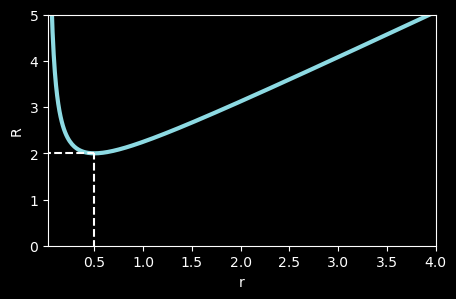

In [7]:
# Plot 1: Areal Radius vs. Coordinate Distance initial data

time_to_plot = Times[0] 

areal_radius_data = plotting_data[time_to_plot]['areal_radius']

r_vs_R_to_plot = areal_radius_data[areal_radius_data.index > 0]

plt.figure(figsize=(5,3))

plt.plot(r_vs_R_to_plot.index, r_vs_R_to_plot, 
         linewidth=3, color='#8ddae3ff')

# Add the guide lines for the throat at R=2M, r=M/2
throat_r = 0.5
throat_R = 2.0
plt.plot(np.ones(10) * throat_r, np.linspace(-1, 2, 10), 
         linestyle='dashed', color='white', 
         label='Minimum at $R=2M, r=M/2$')
plt.plot(np.linspace(-2, throat_r, 10), np.ones(10) * throat_R, 
         linestyle='dashed', color='white')

plt.ylabel('R')
plt.xlabel('r')
plt.ylim(0, 5)
plt.xlim(1/40, 4)
#plt.legend()
#plt.savefig('r-R_plot_new.png', transparent=True, bbox_inches='tight')
plt.show()

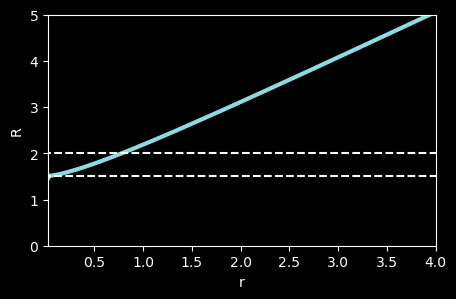

In [8]:
# Plot 2: Areal Radius vs. Coordinate Distance late time

time_to_plot = Times[-1] 

areal_radius_data = plotting_data[time_to_plot]['areal_radius']

r_vs_R_to_plot = areal_radius_data[areal_radius_data.index > 0]

plt.figure(figsize=(5,3))

plt.plot(r_vs_R_to_plot.index, r_vs_R_to_plot, 
         linewidth=3, color='#8ddae3ff')

# Add the guide lines for the throat at R=2M, r=M/2
plt.plot(np.linspace(-2,5,10),np.ones(10)*2,linestyle='dashed',color='white')
plt.plot(np.linspace(-2,5,10),np.ones(10)*1.51,linestyle='dashed',color='white')

plt.ylabel('R')
plt.xlabel('r')
plt.ylim(0, 5)
plt.xlim(1/40, 4)
#plt.legend()
#plt.savefig('r-R_plot_new.png', transparent=True, bbox_inches='tight')
plt.show()

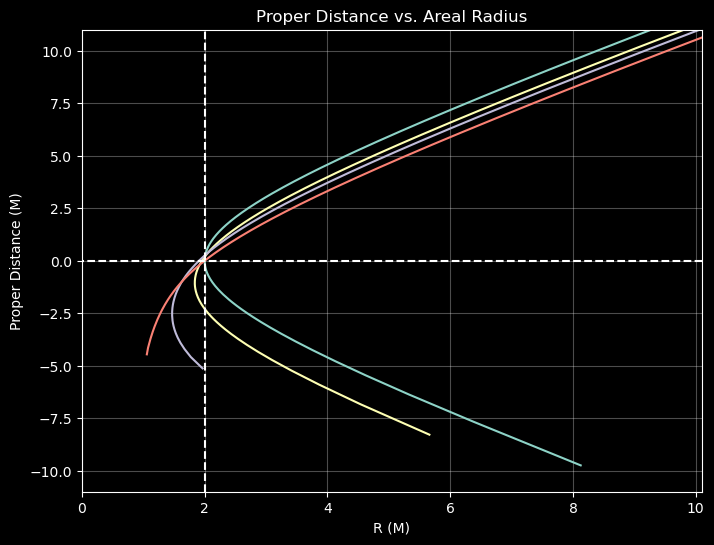

In [9]:
# Plot 3: Areal Radius vs. Proper Distance time evolution.

plt.figure(figsize=(8, 6))
for I in Times[:-2]:
    areal_radius = plotting_data[I]['areal_radius']
    areal_radius_t = areal_radius[areal_radius.index > 1/40]
    proper_distance_t = plotting_data[I]['proper_distance']

    plt.plot(areal_radius_t, proper_distance_t, linestyle='-')

plt.xlabel('R (M)')
plt.ylabel('Proper Distance (M)')
plt.xlim(0,10.1)
plt.plot(np.linspace(-2,11,10),np.zeros(10),linestyle='dashed',color='white')
plt.plot(np.ones(10)*2,np.linspace(-11,11,10),linestyle='dashed',color='white')
plt.ylim(-11,11)
plt.title(f"Proper Distance vs. Areal Radius")
plt.grid(True, alpha=0.3)
plt.show()